# Loan Portfolio

###  문제정의
1. 대출기관이 섹터별로(신용대출, 신차 대출, 중고차 대출 등) 대출 비중에 대한 의사 결정 하기 위해 
2. 머신러닝 기법을 이용하여 개별 대출간 부도확률을 계산하고(대출간 상대적 비교 가능)
3. train_set 기간의 대출 포트폴리오의 수익률과 test_set 기간의 대출 포트폴리오들의 수익률을 계산하여
4. 각 포트폴리오의 성과를 측정함으로서 유용한 정보를 제공할 수 있음


### 분석 데이터 예제와 분석 툴
1. 입수데이터의 기간은 Lending Club에 2010년부터 2015년 년간의 80만여건의 자료   
2. 2012년 부터 2014년 3년간을 train set으로 2015년 데이터를 test_set으로 정의 하였음 
3. 입수항목은 grade, zip, 소득, 대출기간, 대출금액, 대출상태(부도, 완료, 진행), 집소유 등 78개의 컬럼  
4. 분석툴은 Python, Pandas, Sklearn, XGBoost, Jupyter Notebook 를 사용



## 1. Simple EDA & Proprocessing
https://www.kaggle.com/wendykan/lending-club-loan-data 에서 데이터를 입수 함

In [1]:
#https://www.kaggle.com/wendykan/lending-club-loan-data
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import datetime
import time
from collections import defaultdict
import gc
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
%matplotlib inline
#importing all the required ML packages
from sklearn.linear_model import LogisticRegression #logistic regression
from sklearn import svm #support vector Machine
from sklearn.model_selection import train_test_split #training and testing data split
from sklearn import metrics #accuracy measure
from sklearn.metrics import confusion_matrix #for confusion matrix
import seaborn as sns
import matplotlib as mpl
import matplotlib.font_manager as fm
font_location = "/usr/share/fonts/truetype/nanum/NanumGothic.ttf"
font_name = fm.FontProperties(fname=font_location).get_name()
mpl.rc('font', family=font_name)
from pylab import rcParams

#pd.set_option("display.max_columns", 100)
print('Preparing arrays...')
ddir = '/home/bono/local_drive_u/88_alldata/lending/'
#ddir = 'C:/ONEDRIVE_DATA/lending/'
df_data = pd.read_csv(ddir + "loan.csv")
pd.options.display.float_format = '{:.2f}'.format

Preparing arrays...


### 1.1 사용 데이터와 컬럼
- 대출 만기는 3년과 5년으로 구성되어 있는데 분석의 편의 위해서 3년 데이터만 사용함
- 중요 데이터만 추출하여 사용함  
    - issue_d:대출 발행월
    - purpose:대출 상품의 종류(card, mortage, car)
    - term:대출 만기
    - zip_code: 우편번호
    - int_rate: 이자율
    - annual_inc: 연소득
    - grade: 신용등급
    - sub_grade: 신용 보조등급
    - emp_length: 근무 년수
    - dti: 연소득 대비 대출 금액 비율
    - home_ownership:집 자가
    - loan_status: 대출 상태(진행, 종료, 부도)
    - last_pymnt_d: 마지막 이자 지급월
    - total_pymnt:총지급 금액
    - installment:월 지급 이자(원금 포함)
    - last_pymnt_amnt:마지막 이자 금액
    - funded_amnt:대출 원금
 

In [2]:
use_col = ['issue_d','purpose','term','zip_code','int_rate','annual_inc'
           , 'grade','sub_grade','emp_length','dti','home_ownership','loan_status'
           ,'last_pymnt_d','total_pymnt','installment','last_pymnt_amnt','funded_amnt']

df_loan = df_data[use_col]
df_loan = df_loan[df_loan['term'].str.strip() =='36 months']

In [3]:
df_loan.head()

,issue_d,purpose,term,zip_code,int_rate,annual_inc,grade,sub_grade,emp_length,dti,home_ownership,loan_status,last_pymnt_d,total_pymnt,installment,last_pymnt_amnt,funded_amnt
0,Dec-2011,credit_card,36 months,860xx,10.65,24000.00,B,B2,10+ years,27.65,RENT,Fully Paid,Jan-2015,5861.07,162.87,171.62,5000.00
2,Dec-2011,small_business,36 months,606xx,15.96,12252.00,C,C5,10+ years,8.72,RENT,Fully Paid,Jun-2014,3003.65,84.33,649.91,2400.00
3,Dec-2011,other,36 months,917xx,13.49,49200.00,C,C1,10+ years,20.00,RENT,Fully Paid,Jan-2015,12226.30,339.31,357.48,10000.00
5,Dec-2011,wedding,36 months,852xx,7.90,36000.00,A,A4,3 years,11.20,RENT,Fully Paid,Jan-2015,5631.38,156.46,161.03,5000.00
7,Dec-2011,car,36 months,900xx,18.64,48000.00,E,E1,9 years,5.35,RENT,Fully Paid,Jan-2015,3938.14,109.43,111.34,3000.00


### 1.2  년도별 대출 상태별 
- 2012년 부터 대출의 증가하였음
- 문제를 쉽게 풀기 위해서 Charged Off를 부도로 정의하였음. Fully Paid와 비교하면 17% 수준을 나타냄

In [4]:
df_loan = df_loan[~df_loan['loan_status'].str.contains('Does not meet the credit polic')]

In [5]:
pd.crosstab(df_loan.loan_status, pd.to_datetime(df_loan['issue_d']).dt.year, margins =True).style.background_gradient(cmap='summer_r')
#.merge(pd.crosstab(df_loan.loan_status, df_loan.term).apply(lambda r: r/r.sum()), how  = 'left', right_index =True, left_index =True).style.background_gradient(cmap='summer_r')
#df_loan[use_col].groupby(['loan_status','term'])['issue_d'].agg('count').unstack()
#.apply(lambda r: r/r.sum())

issue_d,2007,2008,2009,2010,2011,2012,2013,2014,2015,All
loan_status,,,,,,,,,,
Charged Off,45,247,594,842,1499,5844,9823,8561,1628,29083
Current,0,0,0,0,0,33,42531,106941,253343,402848
Default,0,0,0,0,0,12,121,357,225,715
Fully Paid,206,1315,4122,7624,12602,37488,45858,41886,16474,167575
In Grace Period,0,0,0,0,0,6,675,1298,1996,3975
Issued,0,0,0,0,0,0,0,0,5982,5982
Late (16-30 days),0,0,0,0,0,6,223,540,714,1483
Late (31-120 days),0,0,0,0,0,81,1149,2986,2810,7026
All,251,1562,4716,8466,14101,43470,100380,162569,283172,618687


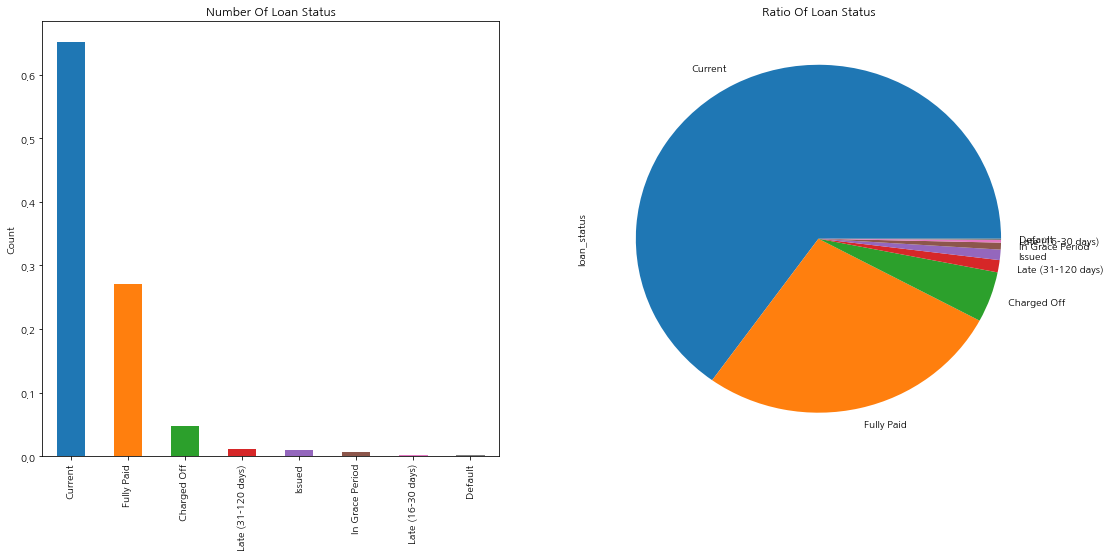

In [6]:
f,ax=plt.subplots(1,2,figsize=(18,8))
#df_loan.groupby('loan_status')['loan_status'].count().plot.bar(ax=ax[0])

df_loan['loan_status'].value_counts(normalize = True).plot.bar(ax=ax[0])
df_loan['loan_status'].value_counts(normalize = True).plot.pie(ax=ax[1])
ax[0].set_title('Number Of Passengers By Pclass')
ax[0].set_ylabel('Count')
ax[0].set_title('Number Of Loan Status')
ax[1].set_title('Ratio Of Loan Status')
plt.show()
#normalize 
#df_loan.groupby('loan_status')['loan_status'].count().plot.pie(ax=ax[1])
#data[['Sex','Survived']].groupby(['Sex']).mean().plot.bar(ax=ax[0])

### 1.3 등급별 대출 상태

In [7]:
pd.crosstab(df_loan.loan_status, df_loan.grade, margins =True).style.background_gradient(cmap='YlGn')
#df_loan[use_col].groupby(['loan_status','term'])['issue_d'].agg('count').unstack()

grade,A,B,C,D,E,F,G,All
loan_status,,,,,,,,
Charged Off,2537,8352,9013,6481,2090,546,64,29083
Current,99093,136927,105765,45396,12988,2392,287,402848
Default,44,172,249,161,71,17,1,715
Fully Paid,38903,60909,40984,20609,5040,1010,120,167575
In Grace Period,349,1093,1349,812,307,56,9,3975
Issued,1386,2105,1659,623,164,38,7,5982
Late (16-30 days),130,348,485,353,127,35,5,1483
Late (31-120 days),478,1770,2323,1634,622,170,29,7026
All,142920,211676,161827,76069,21409,4264,522,618687


In [8]:
#round(pd.crosstab(df_loan.loan_status, df_loan.grade).apply(lambda r: r/r.sum(), axis = 1), 3).style.background_gradient(cmap='YlGn')


### 1.4  섹터별 대출 상태

In [9]:
df_loan.groupby(['loan_status','purpose'])['int_rate'].agg('count').unstack().style.background_gradient(cmap='summer_r')

purpose,car,credit_card,debt_consolidation,educational,home_improvement,house,major_purchase,medical,moving,other,renewable_energy,small_business,vacation,wedding
loan_status,,,,,,,,,,,,,,
Charged Off,306,5414,16932,49,1396,175,588,449,353,2063,39,884,232,203
Current,3832,105123,227579,1,23385,1254,7369,4246,2655,20816,231,3492,2663,202
Default,5,140,442,nan,30,4,7,11,7,48,nan,13,8,nan
Fully Paid,2603,35597,95024,260,9785,1039,4569,1971,1440,9639,181,2724,1252,1491
In Grace Period,27,757,2467,nan,211,27,87,45,34,232,6,47,33,2
Issued,67,1505,3213,nan,369,26,142,75,42,401,5,83,54,nan
Late (16-30 days),9,239,907,nan,88,11,35,12,20,108,nan,36,18,nan
Late (31-120 days),53,1332,4306,nan,387,41,134,101,71,408,8,127,53,5


### 1.5 부도 발생시점

* 수익률을 계산하기 위해서 부도 발생 시점을 확인하는 것은 중요한 단계중에 하나임
* 평균 13.5개월임(대출기간 36개월)
* 만기 

In [10]:
df_loan1 = df_loan.copy()
df_loan1['de_mon'] = pd.to_datetime(df_loan1['last_pymnt_d']).dt.to_period('M') - pd.to_datetime(df_loan1['issue_d']).dt.to_period('M')
print(df_loan1['de_mon'].mean())

13.53556369440931


In [11]:
df_loan1.head(5)

,issue_d,purpose,term,zip_code,int_rate,annual_inc,grade,sub_grade,emp_length,dti,home_ownership,loan_status,last_pymnt_d,total_pymnt,installment,last_pymnt_amnt,funded_amnt,de_mon
0,Dec-2011,credit_card,36 months,860xx,10.65,24000.00,B,B2,10+ years,27.65,RENT,Fully Paid,Jan-2015,5861.07,162.87,171.62,5000.00,37
2,Dec-2011,small_business,36 months,606xx,15.96,12252.00,C,C5,10+ years,8.72,RENT,Fully Paid,Jun-2014,3003.65,84.33,649.91,2400.00,30
3,Dec-2011,other,36 months,917xx,13.49,49200.00,C,C1,10+ years,20.00,RENT,Fully Paid,Jan-2015,12226.30,339.31,357.48,10000.00,37
5,Dec-2011,wedding,36 months,852xx,7.90,36000.00,A,A4,3 years,11.20,RENT,Fully Paid,Jan-2015,5631.38,156.46,161.03,5000.00,37
7,Dec-2011,car,36 months,900xx,18.64,48000.00,E,E1,9 years,5.35,RENT,Fully Paid,Jan-2015,3938.14,109.43,111.34,3000.00,37


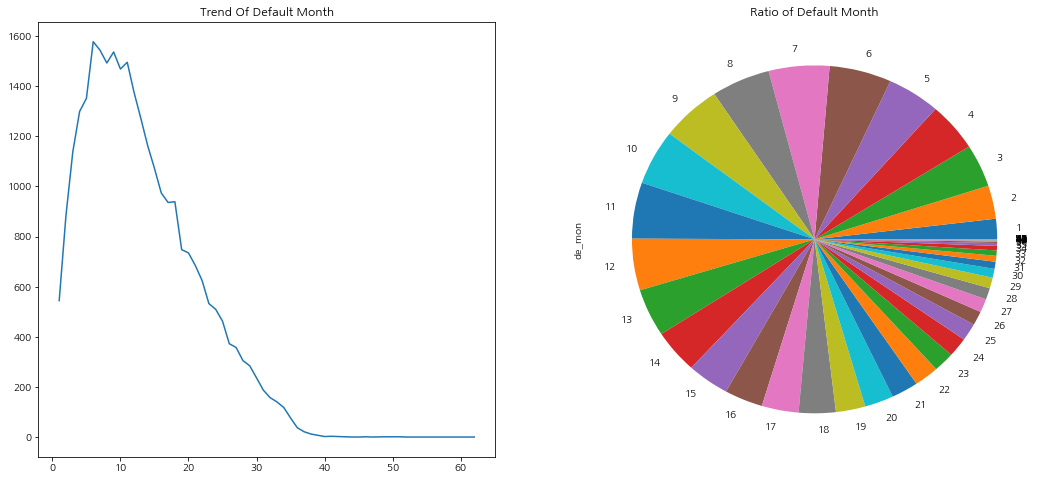

In [12]:
f,ax=plt.subplots(1,2,figsize=(18,8))

da1 = df_loan1[df_loan1.loan_status=='Charged Off']['de_mon'].value_counts().sort_index()
da1.plot.line(ax=ax[0])
da1.plot.pie(ax=ax[1])
ax[0].set_title("Trend Of Default Month")
ax[1].set_title('Ratio of Default Month')
plt.show()

In [13]:
df_a = df_loan.groupby(['loan_status']).agg({'funded_amnt':['sum','count'],'total_pymnt':['sum'], 'installment':['sum']})
df_a

funded_amnt           total_pymnt  installment
                             sum   count           sum          sum
loan_status                                                        
Charged Off         339809650.00   29083  162360215.80  11724090.80
Current            5160802425.00  402848 1933962536.85 169895388.09
Default               8594200.00     715    3935131.42    296018.08
Fully Paid         1980307650.00  167575 2233112017.62  66185974.38
In Grace Period      52595400.00    3975   24599592.51   1790216.43
Issued               77472400.00    5982      49173.30   2540209.65
Late (16-30 days)    19016850.00    1483    9085869.79    653159.29
Late (31-120 days)   88679050.00    7026   40803337.79   3048880.46

12489.801183797299


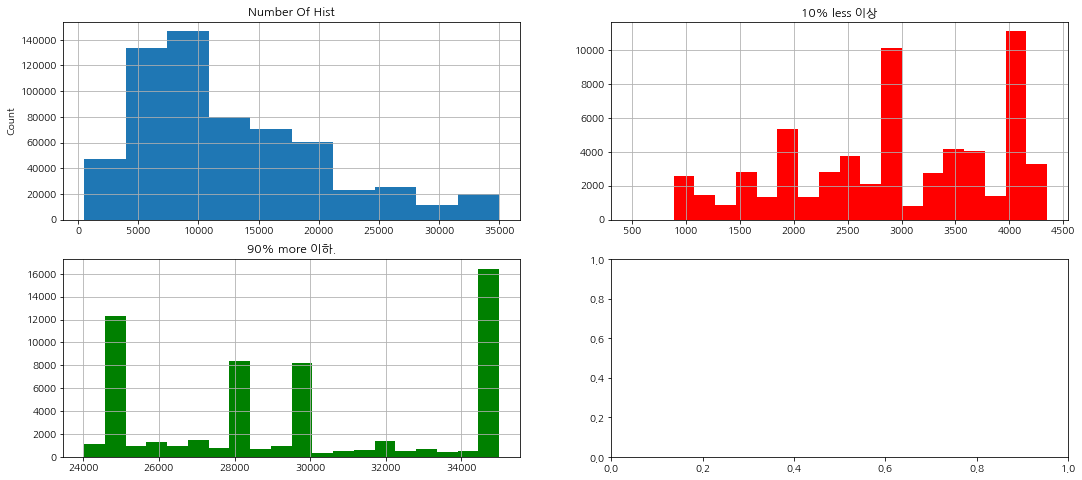

In [14]:
print(df_loan.funded_amnt.mean())
f,ax=plt.subplots(2,2,figsize=(18,8))
df_loan.funded_amnt.hist(bins= 10, ax = ax[0][0]) # [0][i]
ax[0][0].set_title('Number Of Hist')
ax[0][0].set_ylabel('Count')
df_loan[df_loan.funded_amnt.rank(pct=True) < 0.1]['funded_amnt'].hist(bins = 20, ax = ax[0][1], color= 'r')
df_loan[df_loan.funded_amnt.rank(pct=True) > 0.9]['funded_amnt'].hist(bins = 20, ax = ax[1][0], color= 'g')
ax[0][1].set_title('10% less 이상')
ax[1][0].set_title('90% more 이하.')
plt.show()
#.hist(bins= 100, ax = ax[1])#

## 2. 6 대출규모와 연간 소득
* 전체 평균의 대출규모은 12,474 달러임
* 연간소득의 평균은 (72,555)임


In [15]:
#df_loan[df_loan.loan_status == 'Fully Paid'].head(20)

In [16]:
df_loan.describe().style.background_gradient(cmap='terrain_r')

,int_rate,annual_inc,dti,total_pymnt,installment,last_pymnt_amnt,funded_amnt
count,618687,618687,618687,618687,618687,618687,618687
mean,12.0114,72560.3,17.596,7124.62,413.996,1941.56,12489.8
std,3.85541,66272.7,19.816,7297.67,259.401,4031.34,7781.6
min,5.32,0,0,0,15.69,0,500
25%,8.9,43000,11.35,1799.26,220.62,247.11,6625
50%,11.99,60000,17.04,4727.67,342.83,431.25,10000
75%,14.35,87000,23.33,10189.7,544.21,924.81,16000
max,28.99,9e+06,9999,49978.7,1445.46,36188.8,35000


In [17]:
df_data = df_loan.copy()

In [18]:
loan_obj_mod = df_data.select_dtypes(include=['object']).columns

In [19]:
loan_obj_mod = ['purpose', 'term', 'zip_code', 'grade', 'sub_grade', 'emp_length', 'home_ownership', 'loan_status', 'last_pymnt_d']

In [20]:
#loan_obj_mod =[ 'emp_length', 'home_ownership', 'loan_status']

In [21]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
for i in loan_obj_mod:
    print(i)
    df_data[i] = le.fit_transform(df_data[i].astype(str))

purpose
term
zip_code
grade
sub_grade
emp_length
home_ownership
loan_status
last_pymnt_d


In [22]:
df_data.shape

(618687, 17)

##  2.1 부도율 예측

*  Gradinent Boost 알고리즘 적용
* 2011년 - 2013년 데이터를 train으로 하여 2014년 이후의 부도율을 예측함.
* 결과값은 부도 확률로 나타남 

In [23]:
#df_loan.issue_d.to_period('M')
df_train =df_data[((pd.to_datetime(df_loan['issue_d']))>= '2011-01-01') & ((pd.to_datetime(df_loan['issue_d'])) <= '2013-12-31') ]
df_test =df_data[((pd.to_datetime(df_loan['issue_d']))>= '2014-01-01') ]
m_use =['purpose', 'term', 'zip_code', 'int_rate', 'annual_inc',   'grade', 'sub_grade', 'emp_length', 'dti', 'home_ownership',
         'installment', 'funded_amnt', 'target']

features  =['purpose', 'term', 'zip_code', 'int_rate', 'annual_inc',   'grade', 'sub_grade', 'emp_length', 'dti', 'home_ownership',
         'installment', 'funded_amnt']

df_train['target'] = df_train.loan_status.apply(lambda x:1 if x == 0 else 0)
df_test['target'] = df_test.loan_status.apply(lambda x:1 if x == 0 else 0)


In [24]:
X_train = df_train.drop('target', axis = 1)
X_test= df_test.drop('target', axis = 1)
y_train = df_train['target']

In [25]:
features  =['purpose', 'term', 'zip_code', 'int_rate', 'annual_inc',   'grade', 'sub_grade', 'emp_length', 'dti', 'home_ownership',
         'installment', 'funded_amnt']


In [26]:
X_train.head()

,issue_d,purpose,term,zip_code,int_rate,annual_inc,grade,sub_grade,emp_length,dti,home_ownership,loan_status,last_pymnt_d,total_pymnt,installment,last_pymnt_amnt,funded_amnt
0,Dec-2011,1,0,795,10.65,24000.00,1,6,1,27.65,5,3,39,5861.07,162.87,171.62,5000.00
2,Dec-2011,11,0,560,15.96,12252.00,2,14,1,8.72,5,3,55,3003.65,84.33,649.91,2400.00
3,Dec-2011,9,0,838,13.49,49200.00,2,10,1,20.00,5,3,39,12226.30,339.31,357.48,10000.00
5,Dec-2011,13,0,788,7.90,36000.00,0,3,3,11.20,5,3,39,5631.38,156.46,161.03,5000.00
7,Dec-2011,0,0,822,18.64,48000.00,4,20,9,5.35,5,3,39,3938.14,109.43,111.34,3000.00


Index(['purpose', 'term', 'zip_code', 'int_rate', 'annual_inc', 'grade',
       'sub_grade', 'emp_length', 'dti', 'home_ownership', 'installment',
       'funded_amnt'],
      dtype='object')
(157951,)
[0]	train-auc:0.638341	valid-auc:0.638277
Multiple eval metrics have been passed: 'valid-auc' will be used for early stopping.

Will train until valid-auc hasn't improved in 50 rounds.


/home/bono/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/home/bono/anaconda3/lib/python3.6/site-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


[10]	train-auc:0.688409	valid-auc:0.660035
[20]	train-auc:0.708888	valid-auc:0.66246
[30]	train-auc:0.721417	valid-auc:0.661748
[40]	train-auc:0.726758	valid-auc:0.660604
[50]	train-auc:0.73386	valid-auc:0.659991
[60]	train-auc:0.739503	valid-auc:0.658059
Stopping. Best iteration:
[17]	train-auc:0.704628	valid-auc:0.66328

Validating...
[('grade', 131), ('purpose', 146), ('home_ownership', 153), ('emp_length', 283), ('sub_grade', 341), ('installment', 362), ('int_rate', 496), ('funded_amnt', 544), ('zip_code', 571), ('dti', 597), ('annual_inc', 706)]
Check error value: 0.656951


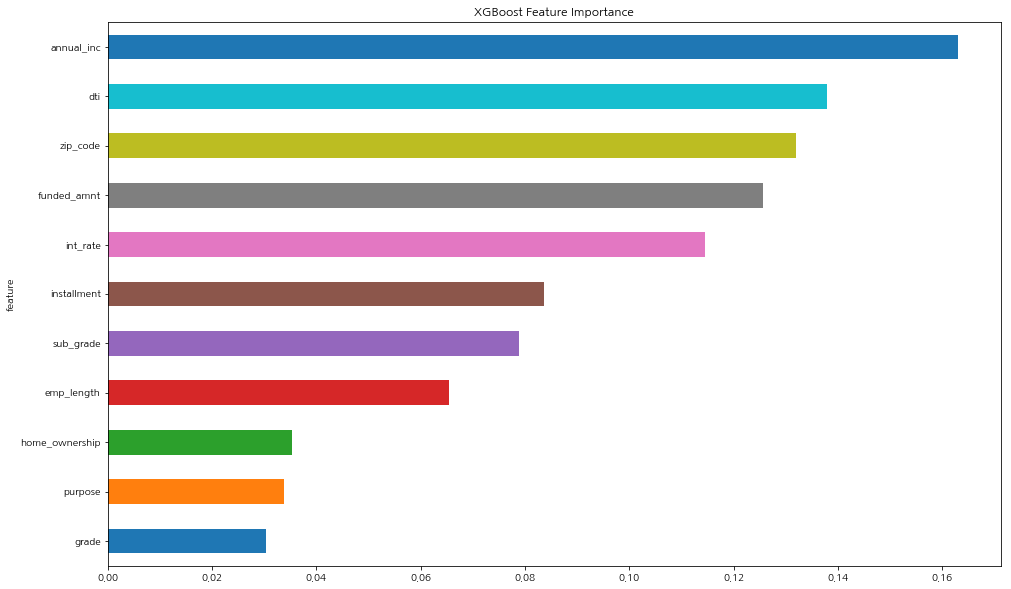

In [27]:
def get_importance(gbm, features):
    #importance = pd.Series(gbm.booster().get_fscore()).sort_values(ascending=False)
    #AttributeError: 'Booster' object has no attribute 'booster'
    #https://github.com/dmlc/xgboost/issues/2119
    outfile = open('xgb.fmap', 'w')
    for i, feat in enumerate(features):
        outfile.write('{0}\t{1}\tq\n'.format(i, feat))
    outfile.close()
    importance = gbm.get_fscore(fmap='xgb.fmap')
    importance = sorted(importance.items(), key=itemgetter(1), reverse=False)
    df = pd.DataFrame(importance, columns=['feature', 'fscore'])
    df['fscore'] = df['fscore'] / df['fscore'].sum()
    plt.figure()
    #df.plot()
    df.plot(kind='barh', x='feature', y='fscore', legend=False, figsize=(16, 10))
    plt.title('XGBoost Feature Importance')
    return importance

### xgb start

import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from sklearn import cross_validation, metrics   #Additional scklearn functions
from sklearn.grid_search import GridSearchCV   #Perforing grid search
import xgboost as xgb
from sklearn.metrics import roc_auc_score
from operator import itemgetter

def runXGboost(df_train, df_test, feature_names, targetY):
    
    xgb_pars = {
    "objective": "binary:logistic",    #  1 reg:linear  2 "binary:logistic", 3 multi:softmax,  4 multi:softprob 
    "booster" : "gbtree",             # 1 gbtree: tree-based, 2 gblinear: linear models
    "eval_metric": "auc", 
    #rmse – root mean square error,   mae – mean absolute error , auc: Area under the curve
    # logloss, mlogloss  – negative log-likelihood   error, merror – Binary classification error rate (0.5 threshold)  merror        
    'min_child_weight': 50, 'eta': 0.3, 'colsample_bytree': 0.3, 'max_depth': 10,  "tree_method": 'exact',
            'subsample': 0.8, 'lambda': 1., 'nthread': 4, 'silent': 1}
    num_boost_round = 115
    early_stopping_rounds = 10
    test_size = 0.2
    
    print(df_train[feature_names].columns)
    print(targetY.shape)
                       
    X_train ,X_valid, y_train, y_valid =  train_test_split(df_train[feature_names].values, targetY, test_size = test_size , random_state= 1)
    dtrain = xgb.DMatrix(X_train, label = y_train)
    dvalid = xgb.DMatrix(X_valid, label=  y_valid)
    dtest = xgb.DMatrix(df_test[feature_names].values)
    watchlist = [(dtrain, 'train'), (dvalid, 'valid')]
    
    gbm_model = xgb.train(xgb_pars, dtrain, 1000, watchlist, early_stopping_rounds=50,
                  maximize=False, verbose_eval=10)
    
    print("Validating...")
    check = gbm_model.predict(dvalid)
    importance = get_importance(gbm_model, features)
    print(importance)
    #importance = gbm.get_fscore(fmap='xgb.fmap')
    score = roc_auc_score(y_valid, check)
    print('Check error value: {:.6f}'.format(score))

    return gbm_model.predict(dtest)

df_test['result'] = runXGboost(X_train, X_test, features,  y_train)

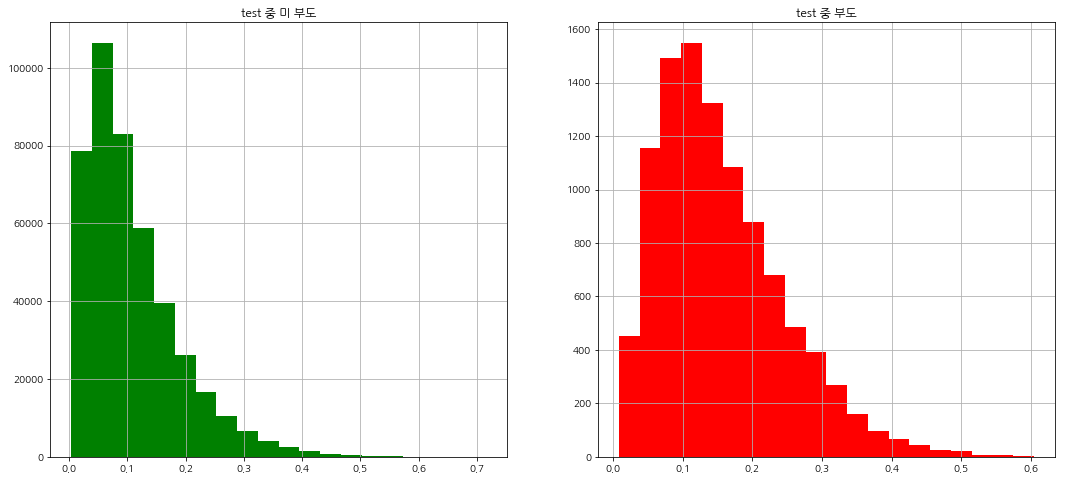

In [28]:
f,ax=plt.subplots(1,2,figsize=(18,8))
#df_test['result'].hist(bins= 20,  color='y', ax = ax[0])
df_test[df_test['target'] == 0]['result'].hist(bins= 20,  color='g', ax = ax[0])
df_test[df_test['target'] == 1]['result'].hist(bins= 20,  color='r', ax = ax[1])
#ax[0].set_title('test 전체')
ax[0].set_title('test 중 미 부도')
ax[1].set_title('test 중 부도')
plt.show()

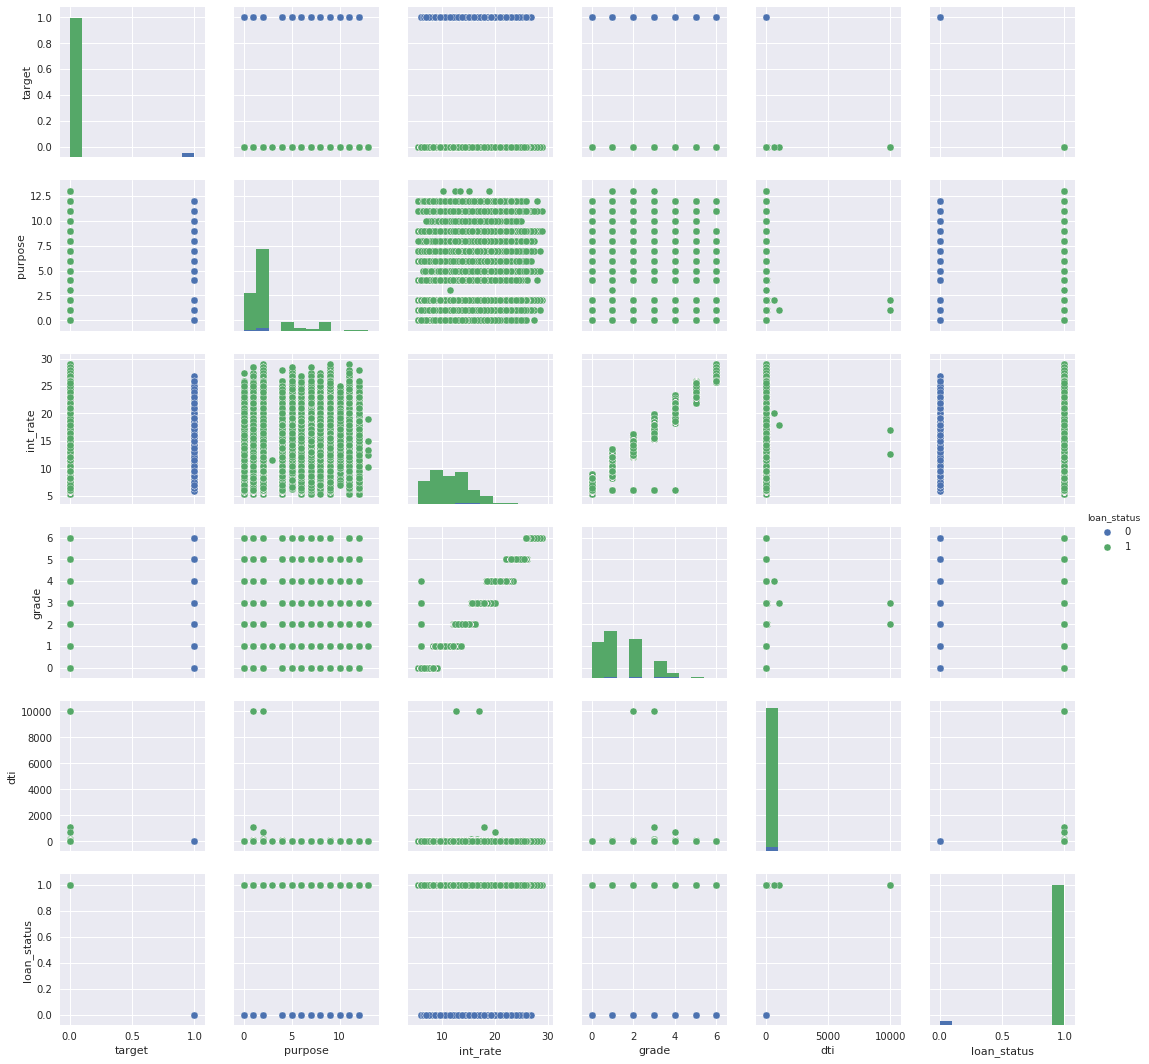

In [29]:
df_pair = df_test[['target','purpose','int_rate','grade','dti','loan_status']]
sns.set()
sns.pairplot(df_pair[df_pair['loan_status'].isin([0,1])], hue='loan_status');

In [30]:
# Part 4.2 단위 포트폴리오 구성과 분석¶
# 단위 포트폴리오는 섹터별로 4개 ('credit_card', 'other','home_improvement', 'debt_consolidation') 별로, 그리고 대출규모 금액가중으로 8분위로 분류하여 구성하였음
# Part 4.2.1 단위 포트폴리오 구성¶
# 대출 금액의 합계가 동일하게 단일 포트폴리오 구성
# 대출금액이 낮을 때와 높을 때 이자율이 높음
# credit_card는 이자율이 가장 높고 other의 이자율이 높음
# 연도별로 2012년과 2015년에는 이자율이 낮아짐
# In [15]:

In [31]:
#df_test.groupby('target')['result2'].mean()
#!jupyter nbconvert --to html *.ipynb

## 3. 단위 포트폴리오 

### 3.1 포트폴리오 구성 

* 단위 포트폴리오는 섹터별로 4개 ('credit_card','home_improvement','debt_consolidation','other') 별로, 그리고 대출규모 금액가중으로 8분위로 분류하여 구성하였음
* 대출 금액의 합계가 동일하게 단일 포트폴리오 구성
* 대출금액이 낮을 때와 높을 때 이자율이 높음
* credit_card는 이자율이 가장 낮고 other의 이자율이 높음
* 연도별로 2012년과 2015년에는 이자율이 낮아짐

In [32]:
pd.options.display.float_format = '{:,.2f}'.format
df_loan['m_rank'] = np.ceil(df_loan.funded_amnt.rank(pct=True) * 10)
df_loan.groupby('m_rank')['funded_amnt'].agg(['count','mean','sum'])
df_loan['funded_amnt'].agg(['count','mean','sum'])
a= np.linspace(0, 7748401550, num=10) 
df_loan['funded_amnt_cum']= df_loan['funded_amnt'].sort_values().cumsum()
df_loan['cum_rank'] = df_loan['funded_amnt_cum'].apply(lambda x:  np.digitize(x, a))
df_loan.groupby('cum_rank').agg({'funded_amnt':['sum','count','mean'],'int_rate':['mean']})#.style.background_gradient(cmap='RdPu')

funded_amnt                   int_rate
                    sum   count      mean     mean
cum_rank                                          
1        860,932,000.00  178413  4,825.50    12.69
2        860,926,625.00   99616  8,642.45    12.28
3        860,933,275.00   80592 10,682.61    11.77
4        860,927,975.00   64862 13,273.23    11.67
5        860,945,925.00   54709 15,736.82    11.46
6        860,926,400.00   44866 19,188.84    11.20
7        860,921,975.00   38823 22,175.57    10.98
8        860,943,100.00   31921 26,971.06    11.11
9        839,820,350.00   24885 33,748.06    13.20

In [33]:
#df_loan

In [34]:
df_loan.head()
df_loan['start_d'] = pd.to_datetime(df_loan.issue_d)

Text(0.5,1,'섹터별 이자율 추이')

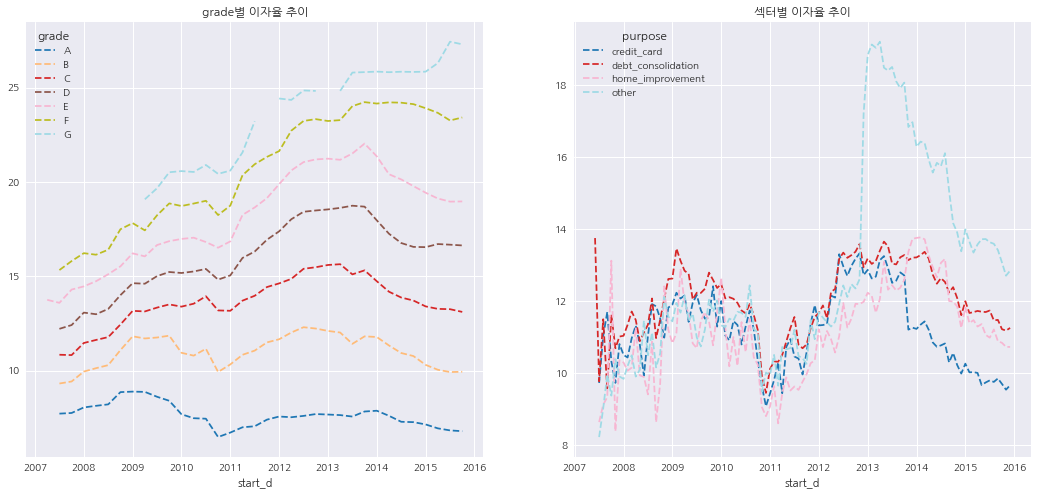

In [35]:
mpl.rc('font', family=font_name)
f,ax=plt.subplots(1,2,figsize=(18,8))
df_loan.groupby(["grade",(pd.Grouper(key='start_d', freq="Q"))])['int_rate'].mean().unstack('grade').plot(cmap='tab20',  linestyle='dashed', ax = ax[0])
p_l1 = ['credit_card', 'other','home_improvement', 'debt_consolidation']
df_loan[df_loan.purpose.isin(p_l1)].groupby(["purpose",(pd.Grouper(key='start_d', freq="M"))])['int_rate'].mean().unstack('purpose').plot(cmap='tab20',  linestyle='dashed', ax = ax[1])


#df_loan[df_loan.purpose.isin(p_l1)]
ax[0].set_title('grade별 이자율 추이')
ax[1].set_title('섹터별 이자율 추이')
#df_loan.groupby(["purpose","issue_d"])['int_rate'].mean().plot()

###  3.2 단위 포트폴리오 수익률 계산

* 미부도시: 이자율 * 원급 지급의 현금 흐름 발생
* 부도시: 원금의 현금흐름이 유출되고 현금 흐름을 발생하지 않는다고 단순 가정 


In [36]:
df_loan['last_pymnt_d']= df_loan.apply(lambda cols: cols['last_pymnt_d'] if pd.isnull(cols['last_pymnt_d']) else cols['issue_d'], axis = 1) 
loan_df= df_loan.copy()
loan_df = loan_df[~loan_df.last_pymnt_d.isnull()]

In [37]:
loan_df['start_d'] = pd.to_datetime(loan_df.issue_d)
loan_df['last_d'] = pd.to_datetime(loan_df.last_pymnt_d)
loan_df['maturity_d'] = loan_df['start_d'].apply(lambda x: x + pd.DateOffset(years=3))


In [38]:
loan_df.head()

,issue_d,purpose,term,zip_code,int_rate,annual_inc,grade,sub_grade,emp_length,dti,...,total_pymnt,installment,last_pymnt_amnt,funded_amnt,m_rank,funded_amnt_cum,cum_rank,start_d,last_d,maturity_d
0,Dec-2011,credit_card,36 months,860xx,10.65,"24,000.00",B,B2,10+ years,27.65,...,"5,861.07",162.87,171.62,"5,000.00",2.00,"317,023,150.00",1,2011-12-01,2011-12-01,2014-12-01
2,Dec-2011,small_business,36 months,606xx,15.96,"12,252.00",C,C5,10+ years,8.72,...,"3,003.65",84.33,649.91,"2,400.00",1.00,"31,273,600.00",1,2011-12-01,2011-12-01,2014-12-01
3,Dec-2011,other,36 months,917xx,13.49,"49,200.00",C,C1,10+ years,20.00,...,"12,226.30",339.31,357.48,"10,000.00",5.00,"2,097,358,625.00",3,2011-12-01,2011-12-01,2014-12-01
5,Dec-2011,wedding,36 months,852xx,7.90,"36,000.00",A,A4,3 years,11.20,...,"5,631.38",156.46,161.03,"5,000.00",2.00,"362,563,150.00",1,2011-12-01,2011-12-01,2014-12-01
7,Dec-2011,car,36 months,900xx,18.64,"48,000.00",E,E1,9 years,5.35,...,"3,938.14",109.43,111.34,"3,000.00",1.00,"77,667,125.00",1,2011-12-01,2011-12-01,2014-12-01


In [39]:
loan_df['issue_d'].count()
#608845
loan_df['cum_rank'].unique()
loan_df['purpose'].unique()
p_l1 = ['credit_card', 'other','home_improvement', 'debt_consolidation']
p_l2 = np.arange(1,9)

In [40]:
def calRetOfPeiord(df_port, pr_cal):
    ret_mo = {}
    for date_i in pr_cal:

        ret_mo[date_i] = calRet(df_port,date_i)
    
    return ret_mo

def calRet(loan_df,  current_month):
    #print(current_month)
    #current_month = '2013-01'
    df_cur = loan_df[(loan_df['start_d'] <= current_month ) & (loan_df['maturity_d'] >=  current_month)]
    #부도 시점을 알 수 없기 때문에 부도가 난 것은 시작 시점에 부도로 인식
    default_df = df_cur[(df_cur['loan_status'].str.strip() == 'Charged Off') & (df_cur['start_d'] == current_month)]
    default_count = len(df_cur[(df_cur['loan_status'].str.strip() == 'Charged Off')])
    
    #print(de_m0)
    safe_df = df_cur[(df_cur['loan_status'].str.strip() != 'Charged Off') ]
    #print(de_p1)
    d1 = sum(default_df['funded_amnt'])
    p1 = sum(safe_df['int_rate'] / 100  * safe_df['funded_amnt'])

    try:
        retOfMonth = (p1 - d1) / sum(df_cur['funded_amnt']) 
    except ZeroDivisionError as e:
        #print(e)
        retOfMonth = 0
    return retOfMonth

df_cal = loan_df[(loan_df['purpose'] == 'credit_card') &  (loan_df['cum_rank'] == 1)]
#calRetOfPeiord(df_cal, pr_cal[:10])

In [41]:
df_cal.shape

(33587, 23)

In [42]:
df_cal.groupby('issue_d').count().shape

(102, 22)

In [43]:
pr_cal = loan_df['start_d'].unique() 
pr_cal.sort()
ret_of_port = {}

In [44]:
for i in p_l1:
    for j in p_l2:
        #print(i + str(j))
        #print(loan_df[(loan_df['purpose'] == i) &  (loan_df['cum_rank'] == j)]['issue_d'].count())
        df_cal = loan_df[(loan_df['purpose'] == i) &  (loan_df['cum_rank'] == j)]
        ret_of_port[(i + '|' + str(j))] = calRetOfPeiord(df_cal, pr_cal)

df_ret = pd.DataFrame.from_dict(ret_of_port)

In [45]:
df_ret.head()

,credit_card|1,credit_card|2,credit_card|3,credit_card|4,credit_card|5,credit_card|6,credit_card|7,credit_card|8,other|1,other|2,...,home_improvement|7,home_improvement|8,debt_consolidation|1,debt_consolidation|2,debt_consolidation|3,debt_consolidation|4,debt_consolidation|5,debt_consolidation|6,debt_consolidation|7,debt_consolidation|8
2007-06-01,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.14,0.00,0.00,0.00,0.00,0.00,0.00
2007-07-01,0.09,0.10,0.00,0.00,0.00,0.00,0.00,0.00,0.08,0.00,...,0.00,0.00,0.09,0.14,0.00,0.00,0.00,0.00,0.00,0.00
2007-08-01,0.09,0.10,0.00,0.14,0.00,-0.45,0.00,0.00,0.09,0.00,...,0.00,0.00,0.10,0.12,0.14,0.12,-1.00,0.00,0.00,0.00
2007-09-01,0.09,-0.43,0.00,0.14,0.00,0.07,0.00,0.00,0.09,0.08,...,0.00,0.00,0.10,0.12,0.12,0.10,0.05,0.00,0.00,0.00
2007-10-01,0.09,0.08,0.00,0.14,0.00,0.07,0.00,0.00,-0.04,0.08,...,0.00,0.00,0.03,-0.46,0.13,0.10,0.05,0.00,0.00,0.00


In [46]:
#df_ret  = df_ret.loc['2012-01-01':'2014-12-01']
#df_ret  = df_ret.loc['2012-01-01':'2014-12-01']
df_ret  = df_ret.loc['2012-01-01':]

In [47]:
df_ret.head()

,credit_card|1,credit_card|2,credit_card|3,credit_card|4,credit_card|5,credit_card|6,credit_card|7,credit_card|8,other|1,other|2,...,home_improvement|7,home_improvement|8,debt_consolidation|1,debt_consolidation|2,debt_consolidation|3,debt_consolidation|4,debt_consolidation|5,debt_consolidation|6,debt_consolidation|7,debt_consolidation|8
2012-01-01,0.09,0.08,0.09,0.08,0.10,0.10,0.10,0.12,0.09,0.09,...,0.09,0.09,0.08,0.08,0.09,0.08,0.10,0.10,0.09,0.11
2012-02-01,0.09,0.09,0.09,0.09,0.09,0.10,0.10,0.09,0.09,0.07,...,0.09,0.09,0.09,0.09,0.09,0.09,0.09,0.10,0.09,0.10
2012-03-01,0.09,0.09,0.09,0.08,0.09,0.10,0.11,0.11,0.09,0.08,...,0.10,0.11,0.09,0.08,0.09,0.09,0.10,0.10,0.10,0.10
2012-04-01,0.09,0.08,0.09,0.08,0.09,0.11,0.10,0.10,0.09,0.07,...,0.06,0.10,0.09,0.08,0.09,0.09,0.09,0.10,0.10,0.11
2012-05-01,0.09,0.09,0.09,0.09,0.09,0.10,0.09,0.10,0.08,0.08,...,0.08,0.10,0.09,0.08,0.09,0.09,0.10,0.09,0.10,0.11


In [48]:
mean_daily_returns  = df_ret.mean()
corr_matrix  = df_ret.corr()

## 3.3 단위 포트폴리오 수익률 분석

* Others 섹터의 단위 포트포리오의 수익률이 높음.
* 소액투자의 단위 포트폴리오이 수익률이 높음

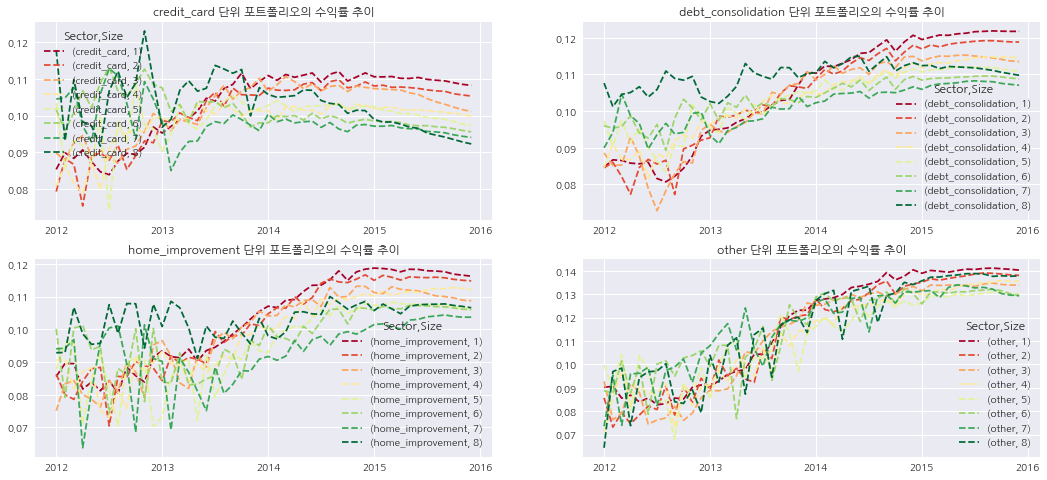

In [49]:
df_ret.tail()
def process_index(k):
    return tuple(k.split("|"))

df_ret.columns  = pd.MultiIndex.from_tuples([process_index(k) for k,v in df_ret.iteritems()])

df_ret.columns.names = ['Sector','Size']

f,axes=plt.subplots(2,2,figsize=(18,8))
pd.options.display.float_format = '{:.4f}'.format
for i, (idx, grp_df) in enumerate(df_ret.groupby(level = 0, axis = 1)):
    grp_df.plot(cmap = 'RdYlGn',linestyle='dashed', ax = axes[i // 2][i % 2])
    axes[i // 2][i % 2].set_title(idx + ' 단위 포트폴리오의 수익률 추이')

## 4.1 ML 을 사용하여 계산한 포트폴리오 수익률

* ML을 사용하면 상대적 부도확률을 계산할 수 있고 팩터의 상대적 비교가 가능함
* ML을 사용하여 부도확률을 계산하고 임계치를 정해서 임계치를 넘으면 부도라 정의 

In [50]:

loan_ml_df = loan_df.join(df_test['result'])
loan_ml_df['result'].describe()

count   433657.0000
mean         0.1091
std          0.0802
min          0.0036
25%          0.0491
50%          0.0884
75%          0.1473
max          0.7157
Name: result, dtype: float64

In [51]:
# 계산된 결과에서 40%가 넣으면 부도로 계산함
loan_ml_df['ml_status'] = loan_ml_df['result'].apply(lambda x: 1 if x > 0.4 else 0)

In [52]:
def calRetOfPeiord_ml(df_port, pr_cal):
    ret_mo = {}
    for date_i in pr_cal:

        ret_mo[date_i] = calRet_ml(df_port,date_i)
    
    return ret_mo

def calRet_ml(loan_ml_df,  current_month):
    #print(loan_ml_df.head())
    #current_month = '2013-01'
    df_cur = loan_ml_df[(loan_ml_df['start_d'] <= current_month ) & (loan_ml_df['maturity_d'] >=  current_month)]
    #print(df_cur.head())
    
    #부도 시점을 알 수 없기 때문에 부도가 난 것은 시작 시점에 부도로 인식
    default_df = df_cur[(df_cur['ml_status']== 1) & (df_cur['start_d'] == current_month)]
    default_count = len(df_cur[(df_cur['ml_status']== 1)])
    
    #print(de_m0)
    safe_df = df_cur[(df_cur['ml_status'] != 1) ]
    #print(de_p1)
    d1 = sum(default_df['funded_amnt'])
    p1 = sum(safe_df['int_rate'] / 100  * safe_df['funded_amnt'])

    try:
        retOfMonth = (p1 - d1) / sum(df_cur['funded_amnt']) 
    except ZeroDivisionError as e:
        #print(e)
        retOfMonth = 0
    return retOfMonth

#df_cal = loan_df[(loan_df['purpose'] == 'credit_card') &  (loan_df['cum_rank'] == 1)]
#calRetOfPeiord(df_cal, pr_cal[:10])

In [53]:
pr_cal = loan_df['start_d'].unique() 
pr_cal.sort()
ret_of_port_ml = {}

for i in p_l1:
    for j in p_l2:
        #print(i + str(j))
        #print(loan_df[(loan_df['purpose'] == i) &  (loan_df['cum_rank'] == j)]['issue_d'].count())
        df_cal = loan_ml_df[(loan_ml_df['purpose'] == i) &  (loan_ml_df['cum_rank'] == j)]
        #print(df_cal.head())
        ret_of_port_ml[(i + '|' + str(j))] = calRetOfPeiord_ml(df_cal, pr_cal)

df_ret_ml = pd.DataFrame.from_dict(ret_of_port_ml)

In [54]:
df_ret_ml  = df_ret_ml.loc['2013-04-01':]

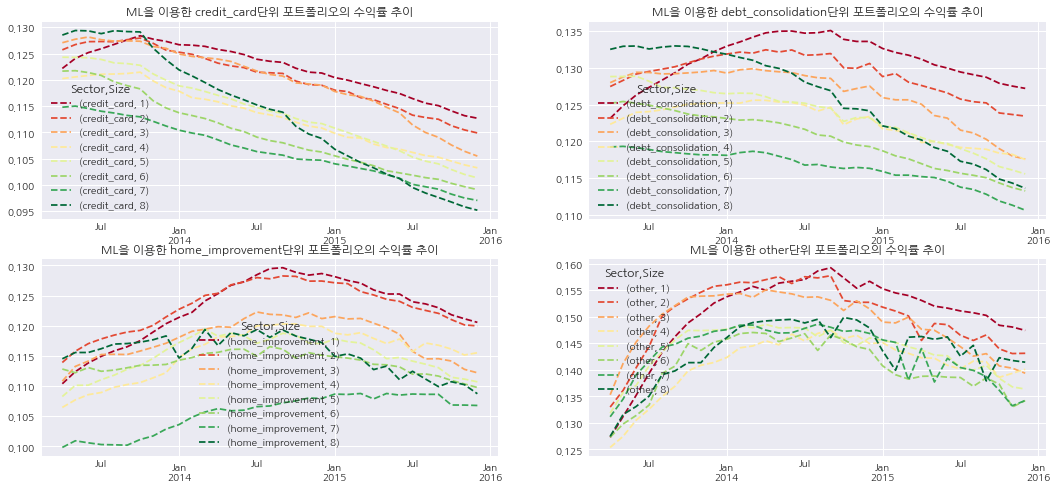

In [55]:
def process_index(k):
    return tuple(k.split("|"))

df_ret_ml.columns  = pd.MultiIndex.from_tuples([process_index(k) for k,v in df_ret_ml.iteritems()])

df_ret_ml.columns.names = ['Sector','Size']

f,axes=plt.subplots(2,2,figsize=(18,8))
pd.options.display.float_format = '{:.4f}'.format
for i, (idx, grp_df) in enumerate(df_ret_ml.groupby(level = 0, axis = 1)):
    grp_df.plot(cmap = 'RdYlGn',linestyle='dashed', ax = axes[i // 2][i % 2])
    axes[i // 2][i % 2].set_title('ML을 이용한 ' + idx + '단위 포트폴리오의 수익률 추이')